# 01 - Sentiment Scoring Pipeline

Implements the sentiment tool described in the project mail. We apply a transformer model (FinBERT by default) to each earnings call transcript and persist engineered sentiment features for downstream analysis.

## Imports & configuration
Tweak the file paths for the JupyterHub server vs. local runs. Use `SAMPLE_SIZE` to dry-run a handful of filings before scaling to the full dataset.

In [1]:
from __future__ import annotations

import hashlib
import json
import logging
from pathlib import Path
from typing import Dict, Iterable, List, Optional

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

TRANSCRIPTS_PATH = Path('data/transcripts.parquet')
CACHE_DIR = Path('sent_cache')
OUTPUT_DIR = Path('output')
OUTPUT_FILE = OUTPUT_DIR / 'sentiment_features.parquet'

TEXT_COLUMN = 'full_transcript'
ID_COLUMNS = ['symbol', 'year', 'quarter']
SAMPLE_SIZE: Optional[int] = 10  # set to None when ready for the full run
BATCH_SIZE = 16
MAX_TOKENS = 450
MIN_TOKENS = 120
OVERLAP_SENTS = 0

OUTPUT_DIR.mkdir(exist_ok=True)
CACHE_DIR.mkdir(exist_ok=True)
logging.info('Sentiment pipeline configured.')


/Users/aryahassibi/Desktop/School/Data and Ai in economics/jupy/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Sentiment pipeline configured.


## Load transcripts
We reuse the parquet file inspected in notebook 00.

In [3]:
if not TRANSCRIPTS_PATH.exists():
    raise FileNotFoundError(f'Transcripts file not found at {TRANSCRIPTS_PATH}. Update TRANSCRIPTS_PATH.')

logging.info('Loading transcripts from %s', TRANSCRIPTS_PATH)
try:
    import pyarrow.parquet as pq
    transcripts_df = pq.read_table(TRANSCRIPTS_PATH).to_pandas()
except Exception as exc:
    logging.warning('Falling back to pandas.read_parquet: %s', exc)
    transcripts_df = pd.read_parquet(TRANSCRIPTS_PATH)

if SAMPLE_SIZE is not None:
    transcripts_df = transcripts_df.head(SAMPLE_SIZE)

logging.info('Loaded %s transcripts', len(transcripts_df))
transcripts_df.head()


INFO: Loading transcripts from data/transcripts.parquet
INFO: Loaded 10 transcripts


,symbol,year,quarter,full_transcript
0,A,2010,1,Operator: Good morning ladies and gentlemen an...
1,A,2010,2,"Operator: Good day, ladies and gentlemen, and ..."
2,A,2011,1,"Operator: Good day, ladies and gentlemen, and ..."
3,A,2011,2,"Operator: Good day, ladies and gentlemen, and ..."
4,A,2011,3,"Operator: Good day, ladies and gentlemen, and ..."


## Sentence segmentation & chunking
Split transcripts into sentences, then pack them into chunks that respect transformer token limits.

In [4]:
import spacy

_NLP = spacy.blank('en')
if 'sentencizer' not in _NLP.pipe_names:
    _NLP.add_pipe('sentencizer')

def split_sentences(text: str) -> List[str]:
    if not isinstance(text, str) or not text.strip():
        return []
    doc = _NLP(' '.join(text.split()))
    return [sent.text.strip() for sent in doc.sents if sent.text.strip()]

def pack_sentences_to_token_chunks(
    sentences: List[str],
    tokenizer,
    max_tokens: int = MAX_TOKENS,
    min_tokens: int = MIN_TOKENS,
    overlap_sents: int = OVERLAP_SENTS,
) -> List[Dict]:
    if not sentences:
        return []
    chunks, buf, buf_tokens = [], [], 0
    i = 0
    while i < len(sentences):
        sent = sentences[i]
        t = len(tokenizer.tokenize(sent))
        if buf and buf_tokens + t > max_tokens:
            chunk_text = ' '.join(buf)
            n_tokens = len(tokenizer.tokenize(chunk_text))
            chunks.append({
                'text': chunk_text,
                'n_tokens': n_tokens,
                'start_idx': i - len(buf),
                'end_idx': i - 1,
            })
            if overlap_sents > 0:
                overlap = buf[-overlap_sents:]
                buf = overlap[:]
                buf_tokens = len(tokenizer.tokenize(' '.join(buf)))
            else:
                buf, buf_tokens = [], 0
            continue
        buf.append(sent)
        buf_tokens += t
        i += 1
    if buf:
        chunk_text = ' '.join(buf)
        n_tokens = len(tokenizer.tokenize(chunk_text))
        if chunks and n_tokens < min_tokens:
            prev = chunks.pop()
            merged = prev['text'] + ' ' + chunk_text
            chunks.append({
                'text': merged,
                'n_tokens': len(tokenizer.tokenize(merged)),
                'start_idx': prev['start_idx'],
                'end_idx': len(sentences) - 1,
            })
        else:
            chunks.append({
                'text': chunk_text,
                'n_tokens': n_tokens,
                'start_idx': len(sentences) - len(buf),
                'end_idx': len(sentences) - 1,
            })
    return chunks


## Load FinBERT (or another Hugging Face classifier)
The default is `ProsusAI/finbert`. Swap `MODEL_NAME` to explore alternatives.

In [5]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = 'ProsusAI/finbert'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

model.to(DEVICE)
model.eval()
LABEL_ORDER = [model.config.id2label[i] for i in range(model.config.num_labels)]
LABEL_ORDER


['positive', 'negative', 'neutral']

## Batched scoring with caching
Minimise repeated model calls by storing chunk-level outputs on disk.

In [6]:
def load_cache(cache_dir: Path = CACHE_DIR) -> Path:
    cache_dir.mkdir(exist_ok=True)
    return cache_dir

def stable_hash(text: str) -> str:
    return hashlib.blake2s(text.encode('utf-8'), digest_size=8).hexdigest()

def maybe_read_cache(cache_dir: Path, key: str):
    fp = cache_dir / f'{key}.json'
    if fp.exists():
        return json.loads(fp.read_text())
    return None

def write_cache(cache_dir: Path, key: str, payload):
    (cache_dir / f'{key}.json').write_text(json.dumps(payload))

@torch.inference_mode()
def score_chunks(
    chunks: List[Dict],
    tokenizer=tokenizer,
    model=model,
    device=DEVICE,
    cache_dir: Path = CACHE_DIR,
    batch_size: int = BATCH_SIZE,
    max_length: int = 512,
    label_order: Iterable[str] = LABEL_ORDER,
) -> List[Dict]:
    cache_dir = load_cache(cache_dir)
    results = []
    batch_texts, batch_keys, pending = [], [], []

    def flush():
        if not batch_texts:
            return
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt',
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits
        probs = F.softmax(logits, dim=-1).cpu().tolist()
        formatted = [
            [{
                'label': label_order[j],
                'score': row[j],
            } for j in range(len(label_order))]
            for row in probs
        ]
        for key, payload, meta in zip(batch_keys, formatted, pending):
            write_cache(cache_dir, key, payload)
            results.append({
                'key': key,
                'scores': payload,
                'n_tokens': meta['n_tokens'],
            })
        batch_texts.clear()
        batch_keys.clear()
        pending.clear()

    for ch in chunks:
        key = stable_hash(ch['text'])
        cached = maybe_read_cache(cache_dir, key)
        if cached is not None:
            results.append({
                'key': key,
                'scores': cached,
                'n_tokens': ch['n_tokens'],
            })
            continue
        batch_texts.append(ch['text'])
        batch_keys.append(key)
        pending.append(ch)
        if len(batch_texts) >= batch_size:
            flush()
    flush()
    return results


## Aggregate chunk scores to transcript-level features
Engineer interpretable metrics (weighted means, dispersion, extremes) to use in regressions.

In [7]:
def distlist_to_array(distlist: List[Dict], label_order: Iterable[str] = LABEL_ORDER):
    label_order = list(label_order)
    if not distlist:
        return np.empty((0, len(label_order))), np.empty((0,))
    probs, weights = [], []
    for item in distlist:
        lookup = {d['label']: d['score'] for d in item['scores']}
        probs.append([lookup[label] for label in label_order])
        weights.append(item['n_tokens'])
    return np.array(probs), np.array(weights)

def aggregate_sentiment(distlist: List[Dict], label_order: Iterable[str] = LABEL_ORDER) -> Dict[str, float]:
    label_order = list(label_order)
    if not distlist:
        return {
            **{f'p_{lab}_wmean': float('nan') for lab in label_order},
            **{f'p_{lab}_std': float('nan') for lab in label_order},
            **{f'p_{lab}_q95': float('nan') for lab in label_order},
            **{f'p_{lab}_q05': float('nan') for lab in label_order},
            **{f'share_{lab}_gt70': float('nan') for lab in label_order},
            'entropy_wmean': float('nan'),
            'n_chunks': 0,
            'n_tokens_total': 0,
            'max_positive': float('nan'),
            'max_negative': float('nan'),
        }
    probs, weights = distlist_to_array(distlist, label_order)
    total_tokens = weights.sum()
    w = weights / total_tokens if total_tokens > 0 else np.ones_like(weights) / len(weights)

    features: Dict[str, float] = {}
    for j, label in enumerate(label_order):
        pj = probs[:, j]
        features[f'p_{label}_wmean'] = float((pj * w).sum())
        features[f'p_{label}_std'] = float(pj.std())
        features[f'p_{label}_q95'] = float(np.quantile(pj, 0.95))
        features[f'p_{label}_q05'] = float(np.quantile(pj, 0.05))
        features[f'share_{label}_gt70'] = float((pj > 0.70).mean())
    entropy = -(probs * np.log(probs + 1e-12)).sum(axis=1)
    features['entropy_wmean'] = float((entropy * w).sum())
    features['n_chunks'] = int(len(distlist))
    features['n_tokens_total'] = int(total_tokens)
    features['max_positive'] = float(probs[:, label_order.index('positive')].max()) if 'positive' in label_order else float('nan')
    features['max_negative'] = float(probs[:, label_order.index('negative')].max()) if 'negative' in label_order else float('nan')
    return features


## Transcript-level wrapper
Collect ID metadata, apply scoring, and build a dataframe of engineered features.

In [8]:
def score_transcript(text: str) -> Dict[str, float]:
    sentences = split_sentences(text)
    chunks = pack_sentences_to_token_chunks(sentences, tokenizer)
    distributions = score_chunks(chunks) if chunks else []
    features = aggregate_sentiment(distributions)
    features['n_sentences'] = len(sentences)
    return features

def score_dataframe(df: pd.DataFrame, text_column: str, id_columns: List[str]) -> pd.DataFrame:
    records = []
    id_columns = [col for col in id_columns if col in df.columns]
    for row in tqdm(df.itertuples(index=False), total=len(df)):
        payload = {col: getattr(row, col) for col in id_columns}
        text = getattr(row, text_column)
        payload.update(score_transcript(text))
        records.append(payload)
    return pd.DataFrame(records)


## Run the sentiment pipeline
Use the cache to avoid recomputation on repeated runs.

In [9]:
sentiment_df = score_dataframe(transcripts_df, TEXT_COLUMN, ID_COLUMNS)
logging.info('Generated sentiment features for %s transcripts', len(sentiment_df))
sentiment_df.head()


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]
INFO: Generated sentiment features for 10 transcripts


,symbol,year,quarter,p_positive_wmean,p_positive_std,p_positive_q95,p_positive_q05,share_positive_gt70,p_negative_wmean,p_negative_std,...,p_neutral_std,p_neutral_q95,p_neutral_q05,share_neutral_gt70,entropy_wmean,n_chunks,n_tokens_total,max_positive,max_negative,n_sentences
0,A,2010,1,0.469938,0.311108,0.931317,0.107376,0.360000,0.145280,0.217575,...,0.329131,0.848629,0.025148,0.280000,0.612724,25,10374,0.956435,0.867143,324
1,A,2010,2,0.565958,0.337969,0.958179,0.097367,0.454545,0.050713,0.091793,...,0.324060,0.885707,0.020418,0.272727,0.537771,22,9341,0.959201,0.454530,388
2,A,2011,1,0.357049,0.260738,0.943069,0.080761,0.142857,0.142774,0.226975,...,0.279511,0.869540,0.040421,0.250000,0.678462,28,11865,0.953654,0.850958,504
3,A,2011,2,0.463796,0.305944,0.953290,0.097362,0.280000,0.024212,0.012790,...,0.304609,0.871286,0.026085,0.320000,0.560847,25,10786,0.959866,0.053804,517
4,A,2011,3,0.483510,0.312496,0.957271,0.081136,0.269231,0.051944,0.076311,...,0.304825,0.872078,0.027633,0.307692,0.593212,26,11086,0.959664,0.367326,524


## Save features to disk
Persist the results for downstream regression and reporting.

In [10]:
sentiment_df.to_parquet(OUTPUT_FILE, index=False)
logging.info('Wrote sentiment features to %s', OUTPUT_FILE)
sentiment_df.to_csv(OUTPUT_DIR / 'sentiment_features.csv', index=False)
logging.info('Also exported CSV for quick inspection.')


INFO: Wrote sentiment features to output/sentiment_features.parquet
INFO: Also exported CSV for quick inspection.


## Feature sanity checks
Inspect distributions to ensure probabilities and engineered metrics look reasonable.

In [11]:
prob_cols = [col for col in sentiment_df.columns if col.startswith('p_')]
sentiment_df[prob_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
p_positive_wmean,10.0,0.407108,0.118934,0.181178,0.366681,0.446662,0.480117,0.565958
p_positive_std,10.0,0.270518,0.066509,0.131009,0.262847,0.297990,0.311106,0.337969
p_positive_q95,10.0,0.843561,0.177143,0.447004,0.836436,0.924079,0.950735,0.958179
p_positive_q05,10.0,0.076360,0.025031,0.031882,0.065108,0.082061,0.094411,0.107376
p_negative_wmean,10.0,0.169827,0.118489,0.024212,0.069605,0.144027,0.233111,0.365886
p_negative_std,10.0,0.201827,0.107209,0.012790,0.120442,0.222275,0.273836,0.333768
p_negative_q95,10.0,0.545176,0.312926,0.050775,0.291056,0.657921,0.710062,0.905505
p_negative_q05,10.0,0.014426,0.003524,0.010989,0.012589,0.013637,0.014240,0.023306
p_neutral_wmean,10.0,0.423065,0.073032,0.292837,0.383692,0.438972,0.477512,0.511992
p_neutral_std,10.0,0.290442,0.025914,0.254873,0.274615,0.288959,0.304771,0.329131


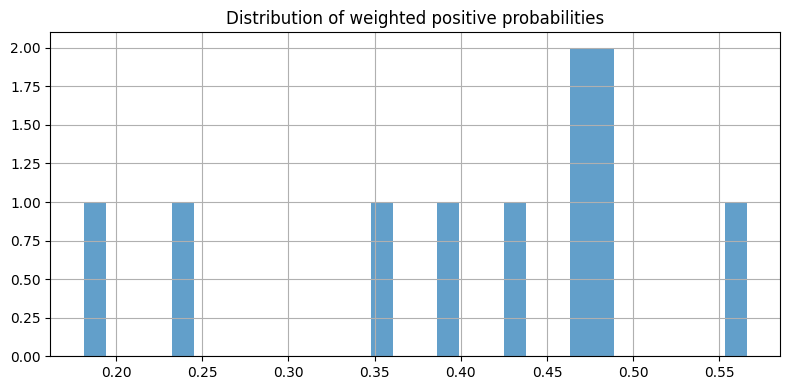

In [12]:
# %matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
sentiment_df['p_positive_wmean'].hist(bins=30, alpha=0.7, ax=ax)
ax.set_title('Distribution of weighted positive probabilities')
plt.tight_layout()
